In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


In [19]:
data = pd.read_csv('./AAPL.csv')
print(data.shape)
print(data.sample(7))

data.info()
data['Date'] = pd.to_datetime(data['Date'])

(1258, 7)
            Date        Open        High         Low       Close   Adj Close  \
546   2020-05-28   79.192497   80.860001   78.907501   79.562500   78.222641   
887   2021-10-04  141.759995  142.210007  138.270004  139.139999  137.924942   
495   2020-03-16   60.487499   64.769997   60.000000   60.552502   59.372055   
1069  2022-06-24  139.899994  141.910004  139.770004  141.660004  141.013931   
471   2020-02-10   78.544998   80.387497   78.462502   80.387497   78.820381   
766   2021-04-13  132.440002  134.660004  131.929993  134.429993  132.831085   
1180  2022-12-01  148.210007  149.130005  146.610001  148.309998  148.083893   

         Volume  
546   133560800  
887    98322000  
495   322423600  
1069   89116800  
471   109348800  
766    91266500  
1180   71250400  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       125

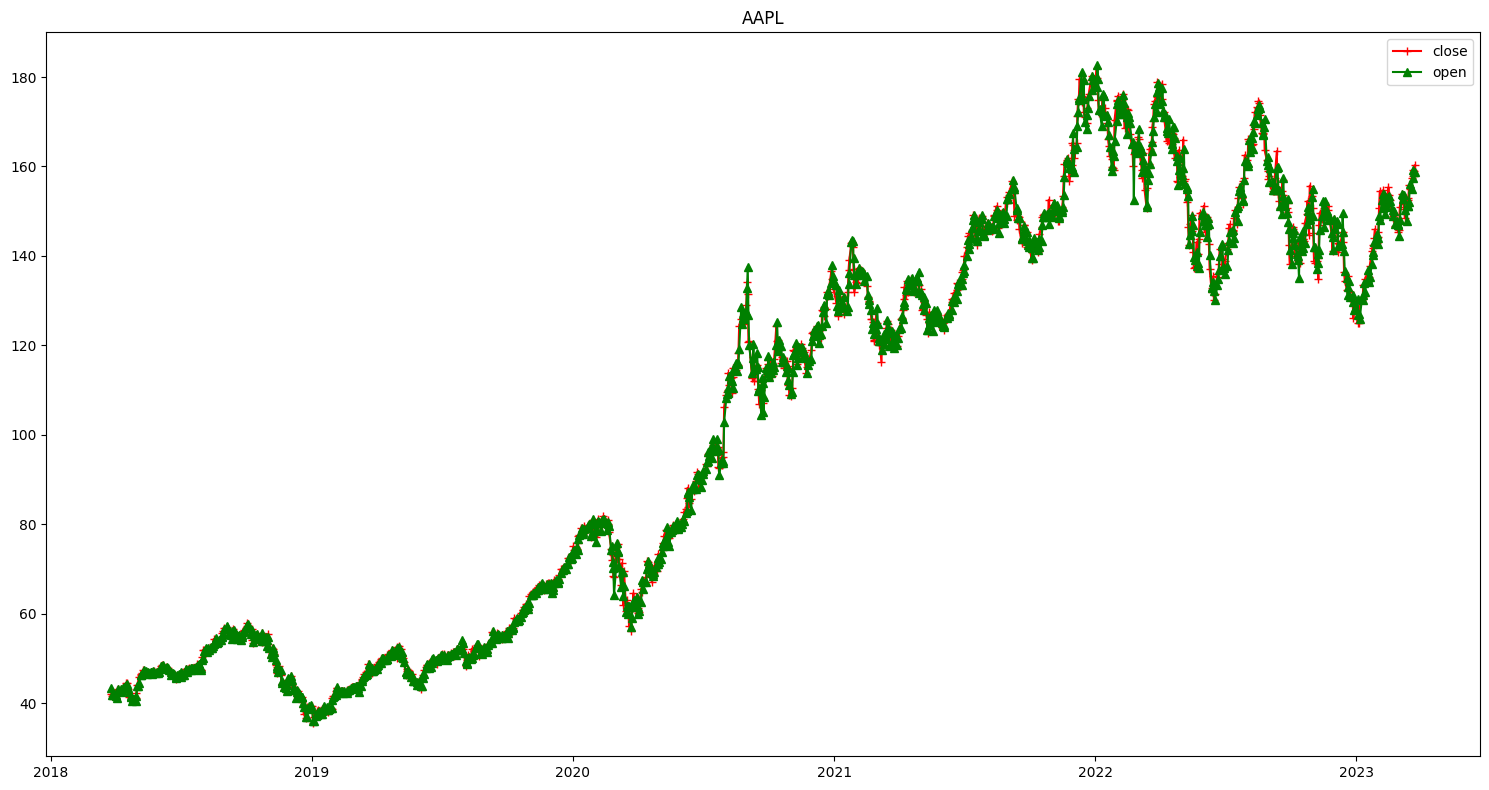

In [20]:
plt.figure(figsize=(15, 8))
c = data
plt.plot(c['Date'], c['Close'], c="r", label="close", marker="+")
plt.plot(c['Date'], c['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()


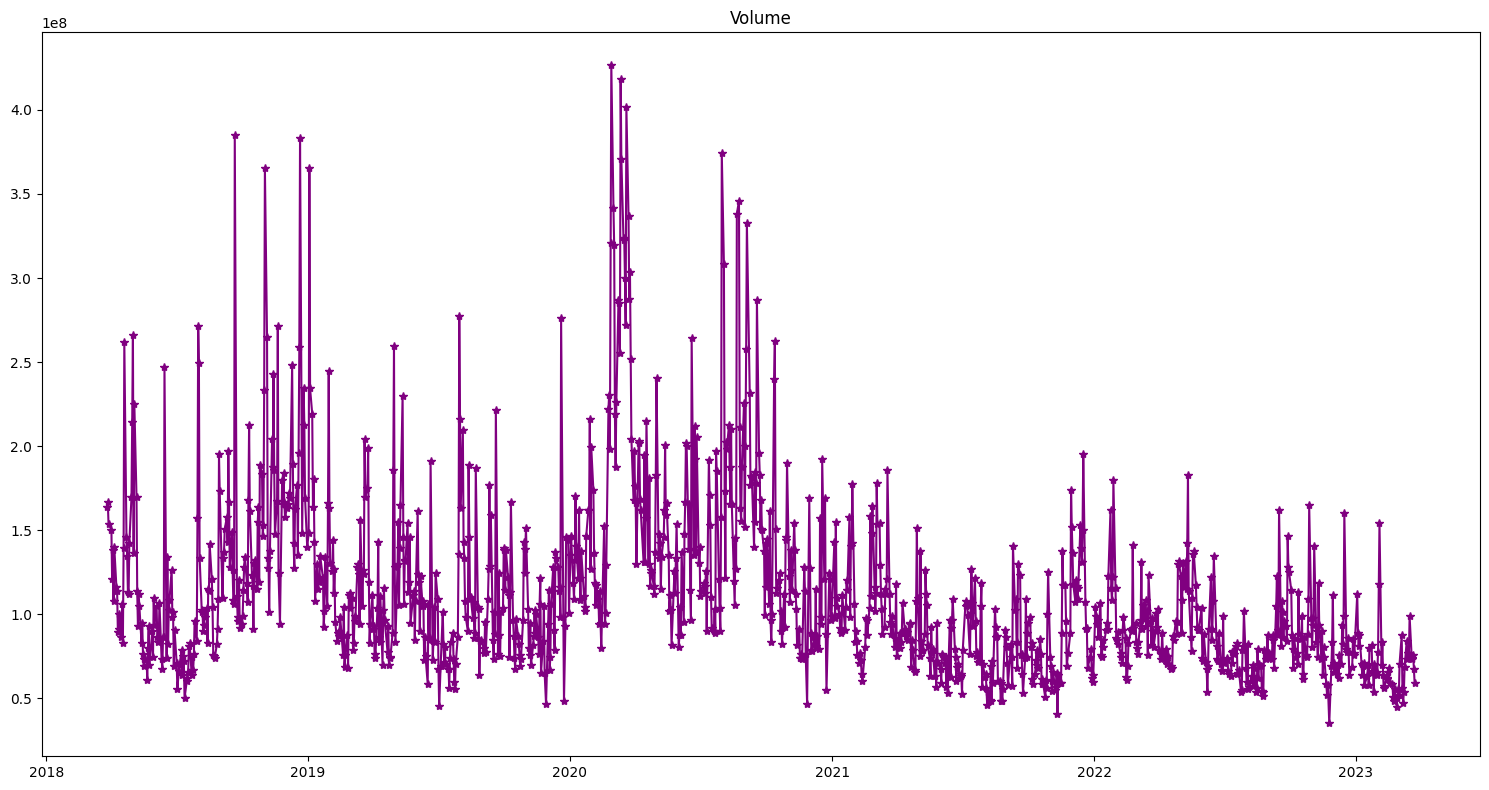

In [21]:

plt.figure(figsize=(15, 8))
c = data
plt.plot(c['Date'], c['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

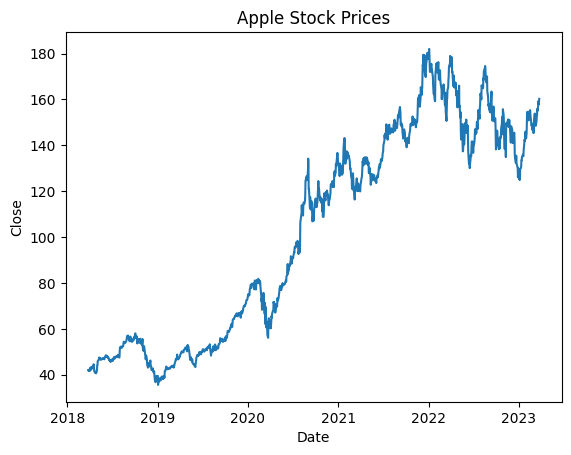

In [22]:
apple = data
prediction_range = apple.loc[(apple['Date'] > datetime(2013,1,1))
 & (apple['Date']<datetime(2018,1,1))]
plt.plot(apple['Date'],apple['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [26]:
close_data = apple.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

[[ 42.084999]
 [ 41.619999]
 [ 41.945   ]
 ...
 [157.830002]
 [158.929993]
 [160.25    ]]
1196


In [27]:

from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
  
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

2023-03-27 22:19:10.539206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:19:10.542228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:19:10.544061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fd0fe2ada20>>

In [29]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-03-27 22:19:25.466594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:19:25.469576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:19:25.471746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 5s 69ms/step - loss: 0.0373
Epoch 2/10
36/36 [==============================] - 2s 65ms/step - loss: 0.0138
Epoch 3/10
36/36 [==============================] - 2s 64ms/step - loss: 0.0118
Epoch 4/10
36/36 [==============================] - 2s 62ms/step - loss: 0.0115
Epoch 5/10
36/36 [==============================] - 2s 63ms/step - loss: 0.0101
Epoch 6/10
36/36 [==============================] - 2s 65ms/step - loss: 0.0098
Epoch 7/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0105
Epoch 8/10
36/36 [==============================] - 3s 70ms/step - loss: 0.0085
Epoch 9/10
36/36 [==============================] - 2s 68ms/step - loss: 0.0091
Epoch 10/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0084


In [30]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-03-27 22:20:29.747195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:20:29.749122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:20:29.750920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 23ms/step
MSE 161.18849920555866
RMSE 12.696003276841049


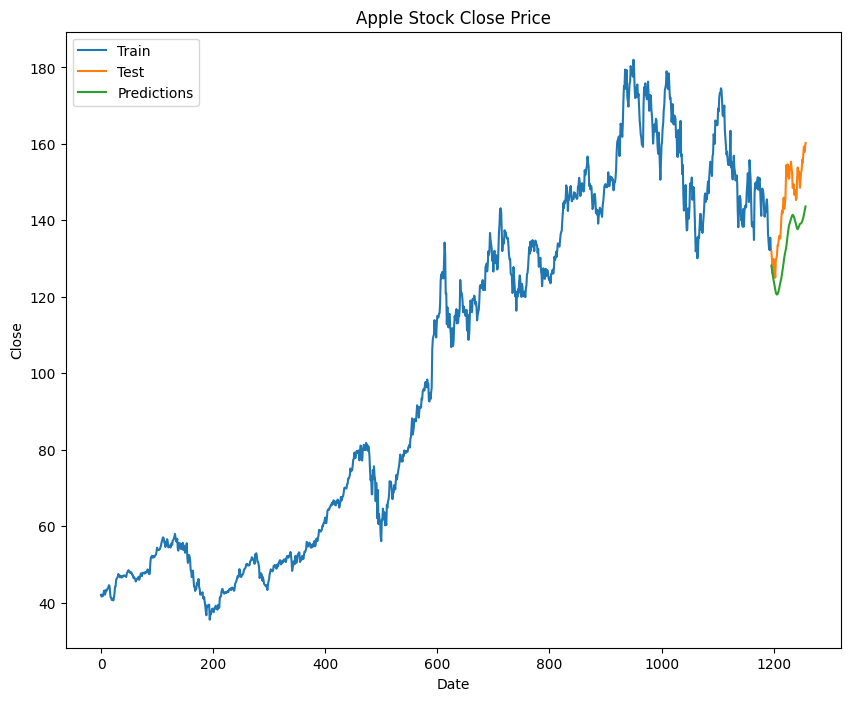

In [32]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])